In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import tensorflow as tf
from numpy import *
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from tensorflow.keras import layers,datasets
from sklearn.preprocessing import LabelEncoder,MinMaxScaler,StandardScaler
from tensorflow import keras
import gc
import warnings
warnings.filterwarnings('ignore')
import lightgbm as lgb
import category_encoders as ce
from sklearn.metrics import f1_score,classification_report,roc_auc_score

In [2]:
pd.set_option('display.max_columns', None)

In [5]:
plan_info['deep_bid_type'].value_counts()

DEEP_BID_DEFAULT         2390
ROI_COEFFICIENT          1673
BID_PER_ACTION             96
DEEP_BID_MIN               29
DEEP_BID_PACING            16
ROI_PACING                 15
AUTO_MIN_SECOND_STAGE      10
SMARTBID                    6
Name: deep_bid_type, dtype: int64

In [6]:
plan_info['deep_bid_type'].isna().sum()

26806

In [7]:
plan_info.shape

(31041, 99)

In [4]:
plan_info = pd.read_csv('./ptom_third_plan.csv')
plan_info.dropna(how='all', inplace=True, axis=1)
plan_info.drop(['ad_start_time', 'ad_end_time', 'remark','origin'], axis=1, inplace=True)
plan_info.dropna(subset=['ad_info'],inplace=True)
plan_info.drop(['ad_id', 'ad_group_id', 'ad_name','media_id','plan_id','launch_op_id','bid_mode','bid_status','bid',
                'budget_mode','budget','opt_status','status','syn_time','update_time','inventory_type'], axis=1, inplace=True)
# 解析json
plan_info['ad_info'] = plan_info['ad_info'].apply(json.loads)
temp = plan_info['ad_info'].apply(pd.Series)
plan_info = pd.concat([plan_info,temp], axis=1)
plan_info.drop('ad_info', axis=1, inplace=True)
temp = plan_info['audience'].apply(pd.Series)
plan_info = pd.concat([plan_info,temp], axis=1)
plan_info.drop('audience', axis=1, inplace=True)
temp = plan_info['action'].apply(pd.Series)
plan_info = pd.concat([plan_info,temp], axis=1)
plan_info.drop('action', axis=1, inplace=True)
plan_info.dropna(how='all', inplace=True, axis=1)

plan_info_2 = plan_info.copy()
plan_info_2.drop(['game_package_batch_id','advanced_creative_type','game_package_desc','game_package_thumbnail_ids',
               'external_url','intelligent_flow_switch','audience_package_id','union_video_type','converted_time_duration',
               'roi_goal','device_type','deep_bid_type','auto_extend_targets'],axis=1,inplace=True)
plan_info_2.drop(['package','open_url','ad_modify_time','deep_cpabid','download_url','download_mode','id','campaign_id',
               'package','ad_create_time','start_time','ad_id','name','status','modify_time','advertiser_id','schedule_type','quick_app_url',
               'end_time','convert_id','audit_reject_reason','download_type','budget_mode','bid','pricing',
               'include_custom_actions','app_type','exclude_flow_package','aweme_fan_behaviors','business_ids','user_type',
               'activate_type','aweme_fan_accounts','aweme_fan_categories','aweme_fans_numbers','article_category',
                'flow_package','carrier','superior_popularity_type','device_brand','exclude_custom_actions','geolocation',
               'opt_status','learning_phase','district'],axis=1,inplace=True)
# 删除老版兴趣行为定向
plan_info_2.drop(['ad_tag','interest_tags','app_behavior_target','app_category','app_ids'],axis=1,inplace=True)
# 删除老版兴趣行为定向
plan_info_2.drop(['retargeting_tags'],axis=1,inplace=True)

In [4]:
image_info = pd.read_csv('./image_info.csv')
# image_info.drop('create_time',axis=1,inplace=True)
# image_info.rename(columns={'create_time':'create_date'},inplace=True)

In [5]:
image_info.head()

,channel_id,source_id,image_id,label_ids
0,6770,254303,19395.0,NaN
1,6770,254304,19418.0,NaN
2,6770,254305,19418.0,NaN
3,6770,254306,19395.0,NaN
4,6770,254307,19511.0,NaN


In [46]:
cc = ['ad_account_id', 'image_id', 'game_id', 'platform', 'android_osv',
       'ios_osv', 'delivery_range', 'inventory_type', 'city', 'location_type',
       'gender', 'age', 'retargeting_type', 'retargeting_tags_include',
       'retargeting_tags_exclude', 'interest_action_mode', 'action_scene',
       'action_days', 'action_categories', 'interest_categories', 'ac',
       'launch_price', 'auto_extend_enabled', 'hide_if_exists',
       'smart_bid_type', 'smart_bid_type', 'adjust_cpa', 'cpa_bid', 'bid2',
       'schedule_time', 'budget', 'hide_if_converted', 'flow_control_mode']

In [49]:
df = pd.merge(plan_info_2,image_info,on=['channel_id','source_id'],how='left')
df.dropna(subset=['image_id'],inplace=True)

In [50]:
launch_report = pd.read_csv('./launch_report.csv',usecols=['tdate','channel_id', 'source_id', 'amount',
       'create_role_num', 'pay_role_user_num', 'new_role_money'])
launch_report.sort_values(by='tdate',inplace=True)
launch_report.drop_duplicates(subset=['channel_id','source_id'],keep='first',inplace=True)
df = pd.merge(df, launch_report,on=['channel_id','source_id'],how='left')
df.drop(df[df['tdate'].isna()].index,inplace=True)

In [51]:
launch_report.head()

,tdate,channel_id,source_id,amount,create_role_num,pay_role_user_num,new_role_money
0,2020-1-1 00:00:00,6867,251792,2165.45,119,0,0
27,2020-1-1 00:00:00,20953,251990,1900.00,75,0,0
28,2020-1-1 00:00:00,20953,252291,1800.00,54,0,0
29,2020-1-1 00:00:00,20953,252292,120.24,2,0,0
30,2020-1-1 00:00:00,20953,252353,1800.00,84,0,0


In [52]:
df['create_role_pay_cost'] = df.apply(lambda x:np.inf if x.pay_role_user_num==0 else x.amount/x.pay_role_user_num, axis=1)

In [53]:
df['platform'] = df['platform'].astype(str)
df['platform'] = df['platform'].map({"['ANDROID']":1,"['IOS']":2})

In [54]:
df['label'] = df.apply(lambda x: 1 if (x.pay_role_user_num>0)&(x.amount>=500) else 0,axis=1)

In [55]:
df['ad_account_id'] = df['ad_account_id'].astype('int')
df['image_id'] = df['image_id'].astype('int')
df.rename(columns={'tdate':'create_date'},inplace=True)
# df['create_date'] = pd.to_datetime(df['create_date']).dt.date
df['create_date'] = pd.to_datetime(df['create_date'])

In [12]:
# 读取image不同窗口期的运营数据
im_train_data_1 = pd.read_csv('./im_data/train_data_1.csv')
# im_train_data_2 = pd.read_csv('./im_data/train_data_2.csv')
im_train_data_3 = pd.read_csv('./im_data/train_data_3.csv')
# im_train_data_4 = pd.read_csv('./im_data/train_data_4.csv')
im_train_data_5 = pd.read_csv('./im_data/train_data_5.csv')
# im_train_data_6 = pd.read_csv('./im_data/train_data_6.csv')
im_train_data_7 = pd.read_csv('./im_data/train_data_7.csv')
# im_train_data_10 = pd.read_csv('./im_data/train_data_10.csv')
for i in [1,3,5,7]:
    exec("im_train_data_%d.drop(['label_ids_%d'],axis=1,inplace=True)"%(i,i))
    exec("im_train_data_%d.rename(columns={'model_run_datetime_%d':'create_date','image_id_%d':'image_id'},inplace=True)"%(i,i,i))
    exec("im_train_data_%d['image_id'] = im_train_data_%d['image_id'].astype('int')"%(i,i))
    exec("im_train_data_%d['create_date'] = pd.to_datetime(im_train_data_%d['create_date'])"%(i,i))

In [13]:
def fill_date(df,col):
    result_df = pd.DataFrame()
    for im_id in df[col].unique():
        temp = df[df[col]==im_id]
        im_date = temp['create_date'].values
        all_date = pd.date_range(temp['create_date'].min()- pd.DateOffset(days=1),temp['create_date'].max(),freq='D')
        new_date = pd.DataFrame(np.setdiff1d(all_date,im_date),columns=['create_date'])
        new_date[col]=im_id
        temp = pd.concat([temp,new_date])
        temp.sort_values(by='create_date',inplace=True)
        temp = temp.reset_index(drop=True)
        temp = temp.fillna(method='ffill')
        temp = temp.fillna(method='bfill')
        result_df = result_df.append(temp)
    return result_df

In [14]:
im_train_data_1 = fill_date(im_train_data_1,col='image_id')
im_train_data_3 = fill_date(im_train_data_3,col='image_id')
im_train_data_5 = fill_date(im_train_data_5,col='image_id')
im_train_data_7 = fill_date(im_train_data_7,col='image_id')

In [15]:
df = pd.merge(df, im_train_data_1, on=['image_id','create_date'],how='left', validate='many_to_one')
# df = pd.merge(df, im_train_data_2, on=['image_id','create_date'],how='left', validate='many_to_one')
df = pd.merge(df, im_train_data_3, on=['image_id','create_date'],how='left', validate='many_to_one')
# df = pd.merge(df, im_train_data_4, on=['image_id','create_date'],how='left', validate='many_to_one')
df = pd.merge(df, im_train_data_5, on=['image_id','create_date'],how='left', validate='many_to_one')
# df = pd.merge(df, im_train_data_6, on=['image_id','create_date'],how='left', validate='many_to_one')
df = pd.merge(df, im_train_data_7, on=['image_id','create_date'],how='left', validate='many_to_one')
# df = pd.merge(df, im_train_data_10, on=['image_id','create_date'],how='left', validate='many_to_one')

In [16]:
# 读取ad不同窗口期的运营数据
ad_train_data_1 = pd.read_csv('./ad_data/train_data_1.csv')
# ad_train_data_2 = pd.read_csv('./ad_data/train_data_2.csv')
ad_train_data_3 = pd.read_csv('./ad_data/train_data_3.csv')
# ad_train_data_4 = pd.read_csv('./ad_data/train_data_4.csv')
ad_train_data_5 = pd.read_csv('./ad_data/train_data_5.csv')
# ad_train_data_6 = pd.read_csv('./ad_data/train_data_6.csv')
ad_train_data_7 = pd.read_csv('./ad_data/train_data_7.csv')
# ad_train_data_10 = pd.read_csv('./ad_data/train_data_10.csv')
for i in [1,3,5,7]:
    exec("ad_train_data_%d.rename(columns={'model_run_datetime':'create_date'},inplace=True)"%(i))
    exec("ad_train_data_%d['ad_account_id'] = ad_train_data_%d['ad_account_id'].astype('int')"%(i,i))
    exec("ad_train_data_%d['create_date'] = pd.to_datetime(ad_train_data_%d['create_date'])"%(i,i))

In [17]:
ad_train_data_1 = fill_date(ad_train_data_1,col='ad_account_id')
ad_train_data_3 = fill_date(ad_train_data_3,col='ad_account_id')
ad_train_data_5 = fill_date(ad_train_data_5,col='ad_account_id')
ad_train_data_7 = fill_date(ad_train_data_7,col='ad_account_id')

In [18]:
df = pd.merge(df, ad_train_data_1, on=['ad_account_id','create_date'],how='left', validate='many_to_one')
# df = pd.merge(df, ad_train_data_2, on=['ad_account_id','create_date'],how='left', validate='many_to_one')
df = pd.merge(df, ad_train_data_3, on=['ad_account_id','create_date'],how='left', validate='many_to_one')
# df = pd.merge(df, ad_train_data_4, on=['ad_account_id','create_date'],how='left', validate='many_to_one')
df = pd.merge(df, ad_train_data_5, on=['ad_account_id','create_date'],how='left', validate='many_to_one')
# df = pd.merge(df, ad_train_data_6, on=['ad_account_id','create_date'],how='left', validate='many_to_one')
df = pd.merge(df, ad_train_data_7, on=['ad_account_id','create_date'],how='left', validate='many_to_one')
# df = pd.merge(df, ad_train_data_10, on=['ad_account_id','create_date'],how='left', validate='many_to_one')

In [19]:
# 读取ad_im不同窗口期的运营数据
ad_im_train_data_1 = pd.read_csv('./ad_im_data/train_data_1.csv')
ad_im_train_data_2 = pd.read_csv('./ad_im_data/train_data_2.csv')
ad_im_train_data_3 = pd.read_csv('./ad_im_data/train_data_3.csv')
ad_im_train_data_4 = pd.read_csv('./ad_im_data/train_data_4.csv')
ad_im_train_data_5 = pd.read_csv('./ad_im_data/train_data_5.csv')
ad_im_train_data_6 = pd.read_csv('./ad_im_data/train_data_6.csv')
ad_im_train_data_7 = pd.read_csv('./ad_im_data/train_data_7.csv')

In [20]:
for i in [1,2,3,4,5,6,7]: 
    exec("ad_im_train_data_%d.rename(columns={'model_run_datetime':'create_date','image_id_%d':'image_id'},inplace=True)"%(i,i))
    exec("ad_im_train_data_%d['image_id'] = ad_im_train_data_%d['image_id'].astype('int')"%(i,i))
    exec("ad_im_train_data_%d['ad_account_id'] = ad_im_train_data_%d['ad_account_id'].astype('int')"%(i,i))
    exec("ad_im_train_data_%d['create_date'] = pd.to_datetime(ad_im_train_data_%d['create_date'])"%(i,i))

In [21]:
df = pd.merge(df, ad_im_train_data_1, on=['ad_account_id','image_id','create_date'],how='left', validate='many_to_one')
df = pd.merge(df, ad_im_train_data_2, on=['ad_account_id','image_id','create_date'],how='left', validate='many_to_one')
df = pd.merge(df, ad_im_train_data_3, on=['ad_account_id','image_id','create_date'],how='left', validate='many_to_one')
df = pd.merge(df, ad_im_train_data_4, on=['ad_account_id','image_id','create_date'],how='left', validate='many_to_one')
df = pd.merge(df, ad_im_train_data_5, on=['ad_account_id','image_id','create_date'],how='left', validate='many_to_one')
df = pd.merge(df, ad_im_train_data_6, on=['ad_account_id','image_id','create_date'],how='left', validate='many_to_one')
df = pd.merge(df, ad_im_train_data_7, on=['ad_account_id','image_id','create_date'],how='left', validate='many_to_one')

In [24]:
cost_col = ['im_create_role_cost_1','im_create_role_cost_3',
            'im_create_role_cost_5','im_create_role_cost_7',
            'ad_create_role_cost_1','ad_create_role_cost_3',
            'ad_create_role_cost_5','ad_create_role_cost_7',
           'ad_im_create_role_cost_1','ad_im_create_role_cost_2','ad_im_create_role_cost_3','ad_im_create_role_cost_4',
            'ad_im_create_role_cost_5','ad_im_create_role_cost_6','ad_im_create_role_cost_7',
           'im_create_role_pay_cost_1','im_create_role_pay_cost_3',
            'im_create_role_pay_cost_5','im_create_role_pay_cost_7',
            'ad_create_role_pay_cost_1','ad_create_role_pay_cost_3',
            'ad_create_role_pay_cost_5','ad_create_role_pay_cost_7',
           'ad_im_create_role_pay_cost_1','ad_im_create_role_pay_cost_2','ad_im_create_role_pay_cost_3','ad_im_create_role_pay_cost_4',
            'ad_im_create_role_pay_cost_5','ad_im_create_role_pay_cost_6','ad_im_create_role_pay_cost_7']
for col in cost_col:
    df[col] = df[col].apply(lambda x:x if x>0 else np.inf)

In [25]:
df['create_time'] = pd.to_datetime(df['create_time'])
df['ad_im_sort_id'] = df.groupby(['ad_account_id','image_id'])['create_time'].rank()
df['ad_game_sort_id'] = df.groupby(['ad_account_id','game_id'])['create_time'].rank()
df['im_ad_sort_id'] = df.groupby(['image_id','ad_account_id'])['create_time'].rank()
df['weekday'] = df['create_time'].dt.weekday
df['month'] = df['create_time'].dt.month

In [26]:
holidays = ['2020-01-01','2020-01-24','2020-01-25','2020-01-26','2020-01-27','2020-01-28',
           '2020-01-29','2020-01-30','2020-01-31','2020-04-04','2020-04-05','2020-04-06',
           '2020-05-01','2020-05-02','2020-05-03','2020-05-04','2020-05-05','2020-06-25',
           '2020-06-26','2020-06-27','2020-10-01','2020-10-02','2020-10-03','2020-10-04','2020-10-05',
           '2020-10-06','2020-10-07','2020-10-08','2021-01-01','2021-01-02','2021-01-03','2021-02-11',
           '2021-02-12','2021-02-13','2021-02-14','2021-02-15','2021-02-16','2021-02-17']

In [27]:
df['create_date'] = pd.to_datetime(df['create_time']).dt.date
df['create_date'] = df['create_date'].astype(str)
df['is_holiday'] = (df.create_date.isin(holidays)).astype(int)

In [28]:
df.drop(['interest_words','action_words','budget','bid2','cpa_bid'],axis=1,inplace=True)

df.drop(['create_role_num','amount','pay_role_user_num','new_role_money','create_role_pay_cost'],axis=1,inplace=True)
df.drop(['channel_id','source_id','create_date'],axis=1,inplace=True)

In [29]:
# 对列表内容进行编码降维
def get_mutil_feature(data):
    cols = ['inventory_type','age','city','retargeting_tags_include','retargeting_tags_exclude','ac','interest_categories',
       'action_scene','action_categories']
    for col in cols:
        if col in ['inventory_type','age']:
            data[col] = data[col].apply(lambda x:x if x==x else [])
            data = data.join(data[col].str.join('|').str.get_dummies().add_prefix(col+'_'))
            data.drop(col,axis=1,inplace=True)
        elif col in ['city','retargeting_tags_include','retargeting_tags_exclude','interest_categories','action_categories']:
            data[col] = data[col].apply(lambda x:x if x==x else [])
            data[col]=data[col].apply(lambda x:[str(i) for i in x])
            temp = data[col].str.join('|').str.get_dummies()
    #         print(temp.shape[1])
            pca = PCA(n_components=0.9)
            temp = pca.fit_transform(temp.values)
            temp = pd.DataFrame(temp,columns = [col+str(i) for i in range(temp.shape[1])])
    #         print(temp.shape[1])
            data = data.join(temp)
            del temp
            data.drop(col,axis=1,inplace=True)
        else:
            data[col] = data[col].apply(lambda x:x if x==x else [])
            data[col]=data[col].apply(lambda x:[str(i) for i in x])
            data = data.join(data[col].str.join('|').str.get_dummies().add_prefix(col+'_'))
            data.drop(col,axis=1,inplace=True)
    
    gc.collect()
    return data

In [30]:
%%time
df = get_mutil_feature(df)

Wall time: 48.6 s


In [31]:
cat_cols = ['ad_account_id','game_id','schedule_time','delivery_range','flow_control_mode',
            'smart_bid_type','hide_if_converted','gender','location_type','launch_price','retargeting_type',
            'android_osv','ios_osv','interest_action_mode',
            'action_days','image_id','label_ids']
for col in cat_cols:
    df[col] = df[col].astype(str)
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])

In [246]:
# cat_cols = ['ad_account_id','game_id','inventory_type','schedule_time','delivery_range','flow_control_mode',
#             'smart_bid_type','hide_if_converted','age','gender','city','location_type','platform','launch_price','retargeting_type',
#             'retargeting_tags_include','retargeting_tags_exclude','ac','android_osv','ios_osv','interest_action_mode',
#             'interest_categories','action_categories','action_days','action_scene','image_id','label_ids']
# for col in cat_cols:
#     df[col] = df[col].astype(str)
#     le = LabelEncoder()
#     df[col] = le.fit_transform(df[col])

In [32]:
df.head()

,ad_account_id,game_id,create_time,smart_bid_type,hide_if_exists,delivery_range,adjust_cpa,hide_if_converted,flow_control_mode,schedule_time,auto_extend_enabled,gender,platform,launch_price,android_osv,location_type,retargeting_type,ios_osv,interest_action_mode,action_days,image_id,label_ids,label,im_amount_1,im_create_role_num_1,im_new_role_money_1,im_pay_role_user_num_1,im_source_num_1,im_valid_source_num_1,im_pay_rate_1,im_create_role_cost_1,im_create_role_pay_cost_1,im_valid_source_rate_1,image_create_role_roi_1,im_amount_3,im_create_role_num_3,im_new_role_money_3,im_pay_role_user_num_3,im_source_num_3,im_valid_source_num_3,im_pay_rate_3,im_create_role_cost_3,im_create_role_pay_cost_3,im_valid_source_rate_3,image_create_role_roi_3,im_amount_5,im_create_role_num_5,im_new_role_money_5,im_pay_role_user_num_5,im_source_num_5,im_valid_source_num_5,im_pay_rate_5,im_create_role_cost_5,im_create_role_pay_cost_5,im_valid_source_rate_5,image_create_role_roi_5,im_amount_7,im_create_role_num_7,im_new_role_money_7,im_pay_role_user_num_7,im_source_num_7,im_valid_source_num_7,im_pay_rate_7,im_create_role_cost_7,im_create_role_pay_cost_7,im_valid_source_rate_7,image_create_role_roi_7,ad_amount_1,ad_create_role_num_1,ad_new_role_money_1,ad_pay_role_user_num_1,ad_source_num_1,ad_valid_source_num_1,ad_pay_rate_1,ad_create_role_cost_1,ad_create_role_pay_cost_1,ad_valid_source_rate_1,ad_create_role_roi_1,ad_amount_3,ad_create_role_num_3,ad_new_role_money_3,ad_pay_role_user_num_3,ad_source_num_3,ad_valid_source_num_3,ad_pay_rate_3,ad_create_role_cost_3,ad_create_role_pay_cost_3,ad_valid_source_rate_3,ad_create_role_roi_3,ad_amount_5,ad_create_role_num_5,ad_new_role_money_5,ad_pay_role_user_num_5,ad_source_num_5,ad_valid_source_num_5,ad_pay_rate_5,ad_create_role_cost_5,ad_create_role_pay_cost_5,ad_valid_source_rate_5,ad_create_role_roi_5,ad_amount_7,ad_create_role_num_7,ad_new_role_money_7,ad_pay_role_user_num_7,ad_source_num_7,ad_valid_source_num_7,ad_pay_rate_7,ad_create_role_cost_7,ad_create_role_pay_cost_7,ad_valid_source_rate_7,ad_create_role_roi_7,ad_im_amount_1,ad_im_create_role_num_1,ad_im_new_role_money_1,ad_im_pay_role_user_num_1,ad_im_source_num_1,ad_im_valid_source_num_1,ad_im_pay_rate_1,ad_im_create_role_cost_1,ad_im_create_role_pay_cost_1,ad_im_valid_source_rate_1,ad_im_create_role_roi_1,ad_im_amount_2,ad_im_create_role_num_2,ad_im_new_role_money_2,ad_im_pay_role_user_num_2,ad_im_source_num_2,ad_im_valid_source_num_2,ad_im_pay_rate_2,ad_im_create_role_cost_2,ad_im_create_role_pay_cost_2,ad_im_valid_source_rate_2,ad_im_create_role_roi_2,ad_im_amount_3,ad_im_create_role_num_3,ad_im_new_role_money_3,ad_im_pay_role_user_num_3,ad_im_source_num_3,ad_im_valid_source_num_3,ad_im_pay_rate_3,ad_im_create_role_cost_3,ad_im_create_role_pay_cost_3,ad_im_valid_source_rate_3,ad_im_create_role_roi_3,ad_im_amount_4,ad_im_create_role_num_4,ad_im_new_role_money_4,ad_im_pay_role_user_num_4,ad_im_source_num_4,ad_im_valid_source_num_4,ad_im_pay_rate_4,ad_im_create_role_cost_4,ad_im_create_role_pay_cost_4,ad_im_valid_source_rate_4,ad_im_create_role_roi_4,ad_im_amount_5,ad_im_create_role_num_5,ad_im_new_role_money_5,ad_im_pay_role_user_num_5,ad_im_source_num_5,ad_im_valid_source_num_5,ad_im_pay_rate_5,ad_im_create_role_cost_5,ad_im_create_role_pay_cost_5,ad_im_valid_source_rate_5,ad_im_create_role_roi_5,ad_im_amount_6,ad_im_create_role_num_6,ad_im_new_role_money_6,ad_im_pay_role_user_num_6,ad_im_source_num_6,ad_im_valid_source_num_6,ad_im_pay_rate_6,ad_im_create_role_cost_6,ad_im_create_role_pay_cost_6,ad_im_valid_source_rate_6,ad_im_create_role_roi_6,ad_im_amount_7,ad_im_create_role_num_7,ad_im_new_role_money_7,ad_im_pay_role_user_num_7,ad_im_source_num_7,ad_im_valid_source_num_7,ad_im_pay_rate_7,ad_im_create_role_cost_7,ad_im_create_role_pay_cost_7,ad_im_valid_source_rate_7,ad_im_create_role_roi_7,ad_im_sort_id,ad_game_sort_id,im_ad_sort_id,weekday,month,is_holiday,inventory_type_INVENTORY_AWEME_FEED,inventory_type_INVENTORY_AWEME_SEARCH,inventory_type_

In [33]:
test_data = df[df['create_time'] >='2020-11-15']
train_data = df[df['create_time'] <'2020-11-15']

In [34]:
test_data.drop(['create_time'],axis=1,inplace=True)
train_data.drop(['create_time'],axis=1,inplace=True)

In [35]:
# train_data, test_data = train_test_split(df, test_size=0.25)
target = train_data['label']
features = train_data.drop(['label'], axis=1)
X_val, x_test, Y_val, y_test = train_test_split(features,target, test_size=0.3)

In [36]:
# 不调参
params = {
"objective": "binary",
"boosting_type": "gbdt",
"learning_rate": 0.01,
"max_depth":8,
"num_leaves":55,
"max_bin":255,
"min_data_in_leaf":101,
"min_child_samples":15,
"feature_fraction": 0.5,
"bagging_fraction":0.6,
"bagging_freq":20,
"lambda_l1":1e-05,
"lambda_l2":0,
"min_split_gain": 0.0,
"metric": "auc",
'is_unbalance':True    
}

train_data = lgb.Dataset(X_val, label=Y_val)
val_data = lgb.Dataset(x_test, label=y_test, reference=train_data)
lgb_b = lgb.train(params, train_data, num_boost_round=8000, early_stopping_rounds=100, valid_sets=[train_data, val_data])

[1]	training's auc: 0.781487	valid_1's auc: 0.702204
Training until validation scores don't improve for 100 rounds
[2]	training's auc: 0.801993	valid_1's auc: 0.716547
[3]	training's auc: 0.819256	valid_1's auc: 0.733149
[4]	training's auc: 0.826618	valid_1's auc: 0.737189
[5]	training's auc: 0.829286	valid_1's auc: 0.741019
[6]	training's auc: 0.835643	valid_1's auc: 0.745027
[7]	training's auc: 0.837569	valid_1's auc: 0.746333
[8]	training's auc: 0.841386	valid_1's auc: 0.750285
[9]	training's auc: 0.843207	valid_1's auc: 0.751102
[10]	training's auc: 0.844267	valid_1's auc: 0.753728
[11]	training's auc: 0.84538	valid_1's auc: 0.755085
[12]	training's auc: 0.846647	valid_1's auc: 0.754194
[13]	training's auc: 0.848019	valid_1's auc: 0.754415
[14]	training's auc: 0.849367	valid_1's auc: 0.755313
[15]	training's auc: 0.850593	valid_1's auc: 0.75557
[16]	training's auc: 0.851865	valid_1's auc: 0.756368
[17]	training's auc: 0.85213	valid_1's auc: 0.757643
[18]	training's auc: 0.852596	va

[157]	training's auc: 0.903306	valid_1's auc: 0.77186
[158]	training's auc: 0.903551	valid_1's auc: 0.771831
[159]	training's auc: 0.903665	valid_1's auc: 0.771786
[160]	training's auc: 0.903737	valid_1's auc: 0.77173
[161]	training's auc: 0.903951	valid_1's auc: 0.771793
[162]	training's auc: 0.904114	valid_1's auc: 0.771846
[163]	training's auc: 0.904295	valid_1's auc: 0.771866
[164]	training's auc: 0.904376	valid_1's auc: 0.771909
[165]	training's auc: 0.904606	valid_1's auc: 0.771928
[166]	training's auc: 0.904854	valid_1's auc: 0.771971
[167]	training's auc: 0.90498	valid_1's auc: 0.772035
[168]	training's auc: 0.905196	valid_1's auc: 0.772134
[169]	training's auc: 0.905364	valid_1's auc: 0.772108
[170]	training's auc: 0.905551	valid_1's auc: 0.772243
[171]	training's auc: 0.905722	valid_1's auc: 0.772116
[172]	training's auc: 0.905836	valid_1's auc: 0.772103
[173]	training's auc: 0.905992	valid_1's auc: 0.772136
[174]	training's auc: 0.906129	valid_1's auc: 0.772033
[175]	trainin

[327]	training's auc: 0.927105	valid_1's auc: 0.773551
[328]	training's auc: 0.92721	valid_1's auc: 0.773603
[329]	training's auc: 0.927388	valid_1's auc: 0.773538
[330]	training's auc: 0.927459	valid_1's auc: 0.773536
[331]	training's auc: 0.927689	valid_1's auc: 0.77359
[332]	training's auc: 0.927845	valid_1's auc: 0.773559
[333]	training's auc: 0.927992	valid_1's auc: 0.773622
[334]	training's auc: 0.928121	valid_1's auc: 0.77365
[335]	training's auc: 0.928205	valid_1's auc: 0.773568
[336]	training's auc: 0.928298	valid_1's auc: 0.773519
[337]	training's auc: 0.928394	valid_1's auc: 0.773587
[338]	training's auc: 0.928512	valid_1's auc: 0.77372
[339]	training's auc: 0.928575	valid_1's auc: 0.773694
[340]	training's auc: 0.928717	valid_1's auc: 0.7738
[341]	training's auc: 0.928923	valid_1's auc: 0.773786
[342]	training's auc: 0.929103	valid_1's auc: 0.77386
[343]	training's auc: 0.929219	valid_1's auc: 0.773925
[344]	training's auc: 0.929283	valid_1's auc: 0.773895
[345]	training's 

[484]	training's auc: 0.943113	valid_1's auc: 0.774866
[485]	training's auc: 0.943158	valid_1's auc: 0.774837
[486]	training's auc: 0.943288	valid_1's auc: 0.774922
[487]	training's auc: 0.943361	valid_1's auc: 0.774886
[488]	training's auc: 0.943426	valid_1's auc: 0.774788
[489]	training's auc: 0.943469	valid_1's auc: 0.774777
[490]	training's auc: 0.943529	valid_1's auc: 0.77477
[491]	training's auc: 0.943624	valid_1's auc: 0.774727
[492]	training's auc: 0.943702	valid_1's auc: 0.77473
[493]	training's auc: 0.943778	valid_1's auc: 0.774739
[494]	training's auc: 0.943825	valid_1's auc: 0.77473
[495]	training's auc: 0.943922	valid_1's auc: 0.774697
[496]	training's auc: 0.943953	valid_1's auc: 0.774741
[497]	training's auc: 0.944054	valid_1's auc: 0.774805
[498]	training's auc: 0.944126	valid_1's auc: 0.774781
[499]	training's auc: 0.944211	valid_1's auc: 0.774734
[500]	training's auc: 0.94429	valid_1's auc: 0.774712
[501]	training's auc: 0.944352	valid_1's auc: 0.774654
[502]	training

[651]	training's auc: 0.955488	valid_1's auc: 0.77483
[652]	training's auc: 0.955548	valid_1's auc: 0.774831
[653]	training's auc: 0.955618	valid_1's auc: 0.774787
[654]	training's auc: 0.955747	valid_1's auc: 0.774756
[655]	training's auc: 0.955812	valid_1's auc: 0.774727
[656]	training's auc: 0.955867	valid_1's auc: 0.77465
[657]	training's auc: 0.955906	valid_1's auc: 0.774606
[658]	training's auc: 0.955949	valid_1's auc: 0.77456
[659]	training's auc: 0.956021	valid_1's auc: 0.774632
[660]	training's auc: 0.956111	valid_1's auc: 0.774632
[661]	training's auc: 0.956191	valid_1's auc: 0.774653
[662]	training's auc: 0.95625	valid_1's auc: 0.774598
[663]	training's auc: 0.956307	valid_1's auc: 0.774571
[664]	training's auc: 0.956396	valid_1's auc: 0.774567
[665]	training's auc: 0.956501	valid_1's auc: 0.774593
[666]	training's auc: 0.9566	valid_1's auc: 0.77458
[667]	training's auc: 0.956661	valid_1's auc: 0.774587
[668]	training's auc: 0.956718	valid_1's auc: 0.774561
[669]	training's 

In [37]:
# 用train_data_pay_7_test数据集进行测试
target_test = test_data['label']
features_test = test_data.drop(['label'], axis=1)
y_predict = lgb_b.predict(features_test)

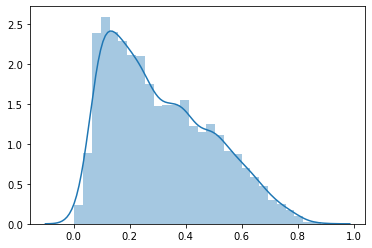

In [38]:
sns.distplot(y_predict)
plt.show()

In [39]:
roc_auc_score(target_test,y_predict)

0.7111247385824364

In [40]:
s = pd.Series(y_predict)
s.sort_values(ascending=False).reset_index(drop=True)[int(y_predict.shape[0] *0.07)]

0.6196742661066433

In [41]:
y_predict = list(map(lambda x:1 if x>=s.sort_values(ascending=False).reset_index(drop=True)[int(y_predict.shape[0] *0.07)] else 0,y_predict))

In [42]:
print(classification_report(target_test, y_predict))

              precision    recall  f1-score   support

           0       0.90      0.94      0.92      5014
           1       0.30      0.18      0.23       642

    accuracy                           0.86      5656
   macro avg       0.60      0.56      0.57      5656
weighted avg       0.83      0.86      0.84      5656



<Figure size 864x432 with 0 Axes>

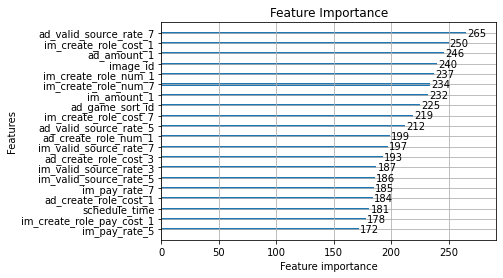

In [43]:
plt.figure(figsize=(12,6))
lgb.plot_importance(lgb_b, max_num_features=20)
plt.title('Feature Importance')
plt.show()